In [1]:
import os
import os.path
import random
import gc
import numpy as np
import pandas as pd
import scipy.sparse
from tqdm import tqdm

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [4]:
sns.set()

In [5]:
import pickle

def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

## Read Data

In [6]:
DATA_DIR = '../input/msci-h5-sparse-transform'
%ls $DATA_DIR -lh

total 7.1G
-rw-r--r-- 1 nobody nogroup  25K Nov  2 12:50 __notebook__.ipynb
-rw-r--r-- 1 nobody nogroup  25K Nov  2 12:50 __output__.json
-rw-r--r-- 1 nobody nogroup 293K Nov  2 12:50 __results__.html
-rw-r--r-- 1 nobody nogroup    0 Nov  2 12:50 custom.css
-rw-r--r-- 1 nobody nogroup 359M Nov  2 12:50 evaluation_ids.parquet
-rw-r--r-- 1 nobody nogroup 3.8M Nov  2 12:50 metadata.parquet
-rw-r--r-- 1 nobody nogroup 108K Nov  2 12:50 metadata_cite_day_2_donor_27678.parquet
-rw-r--r-- 1 nobody nogroup 252M Nov  2 12:50 sample_submission.parquet
-rw-r--r-- 1 nobody nogroup 856K Nov  2 12:50 test_cite_inputs_day_2_donor_27678_idx.npz
-rw-r--r-- 1 nobody nogroup  78M Nov  2 12:50 test_cite_inputs_day_2_donor_27678_val.sparse.npz
-rw-r--r-- 1 nobody nogroup 1.8M Nov  2 12:50 test_cite_inputs_idx.npz
-rw-r--r-- 1 nobody nogroup 488M Nov  2 12:51 test_cite_inputs_val.sparse.npz
-rw-r--r-- 1 nobody nogroup 8.4M Nov  2 12:50 test_multi_inputs_idx.npz
-rw-r--r-- 1 nobody nogroup 1.7G Nov  2 12:51 

In [7]:
%%time
train_inp = scipy.sparse.load_npz(f'{DATA_DIR}/train_multi_inputs_val.sparse.npz')
train_inp.shape

CPU times: user 28.5 s, sys: 2.02 s, total: 30.6 s
Wall time: 58.7 s


(105942, 228942)

In [8]:
%%time
train_tar = scipy.sparse.load_npz(f'{DATA_DIR}/train_multi_targets_val.sparse.npz')
train_tar.shape

CPU times: user 12.8 s, sys: 1.86 s, total: 14.7 s
Wall time: 22.9 s


(105942, 23418)

## Modeling

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [11]:
class SparseDataset(TensorDataset):
    # https://discuss.pytorch.org/t/dataloader-loads-data-very-slow-on-sparse-tensor/117391/2
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    
    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]
    
    def __len__(self):
        return self.inputs.shape[0]

In [12]:
def sparse_coo_to_tensor(coo):
    values = coo.data
    indices = np.vstack((coo.row, coo.col))
    shape = coo.shape
    
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    s = torch.Size(shape)
    
    return torch.sparse.FloatTensor(i, v, s)

In [13]:
def sparse_batch_collate(batch):
    inputs_batch, targets_batch = zip(*batch)
    inputs_batch = sparse_coo_to_tensor(scipy.sparse.vstack(inputs_batch).tocoo())
    targets_batch = sparse_coo_to_tensor(scipy.sparse.vstack(targets_batch).tocoo())
    return inputs_batch, targets_batch

In [14]:
full_ds = SparseDataset(train_inp, train_tar)
train_sz = 84992
val_sz = len(full_ds) - train_sz
train_ds, val_ds = random_split(full_ds, 
                                [train_sz, val_sz],
                                generator=torch.Generator().manual_seed(42))

In [15]:
batch_size = 1024
train_loader = DataLoader(train_ds, 
                          batch_size=batch_size, 
                          shuffle=True,
                          collate_fn=sparse_batch_collate)
val_loader = DataLoader(val_ds, 
                        batch_size=batch_size, 
                        shuffle=False,
                        collate_fn=sparse_batch_collate)

In [16]:
class Net(nn.Module):
    def __init__(self):
        """In the constructor we instantiate two nn.Linear modules and assign them as
        member variables (self).
        """
        super(Net, self).__init__()
        self.linear1 = nn.Linear(228942, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.linear3 = nn.Linear(128, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.linear4 = nn.Linear(128, 23418)


    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.linear4(x)
        x = F.relu(x)

        return x

In [17]:
def train_model(train_loader, model, optimizer):
    
    model.train()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        y = y.to_dense()
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        total += batch
        sum_corr += batch * corr
    
    train_corr = sum_corr/total 
    return train_corr

In [18]:
def model_eval(model, val_loader):
    model.eval()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    
    for i, (x, y) in enumerate(val_loader):
        x = x.to(device)
        y = y.to(device)
        
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        y = y.to_dense()
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        total += batch
        sum_corr += batch * corr
        
    val_corr = sum_corr/total
    return val_corr

In [19]:
net = Net().to(device)
learning_rate = 0.0001
weight_decay = 0.001 
optimizer = optim.Adam(net.parameters(),
                       lr=learning_rate,
                       weight_decay=weight_decay)

In [20]:
%%time
epochs = 100
train_corrs = []
val_corrs = []
best_val_corr = 0.0
best_epoch = 0

for epoch in range(epochs):
    # train
    print('epoch', epoch)
    train_corr = train_model(train_loader, net, optimizer)
    train_corr = float(train_corr.to('cpu').detach().numpy())
    train_corrs.append(train_corr)
    print(f'train corr: {train_corr:.4f}')
    
    # val
    val_corr = model_eval(net, val_loader)
    val_corr = float(val_corr.to('cpu').detach().numpy())
    val_corrs.append(val_corr)
    print(f'val corr: {val_corr:.4f}')
    print()
    
    # early stoppage
#     if epoch - best_epoch > 3:
#         if val_corr < best_val_corr:
#             print(f'**Early Stoppage** We are stopping at epoch {epoch}...')
#             print(f'Best epoch: epoch {best_epoch}')
#             print(f'Best val correlation: {val_corr: .4f}')
#             break
            
#     # update
#     if val_corr > best_val_corr:
#         best_val_corr = max([best_val_corr, val_corr])
#         best_epoch = epoch
# #         print(epoch, best_epoch, best_val_corr)
# #         print()

epoch 0
train corr: 0.1536
val corr: 0.3528

epoch 1
train corr: 0.4829
val corr: 0.5495

epoch 2
train corr: 0.5761
val corr: 0.5824

epoch 3
train corr: 0.5962
val corr: 0.5923

epoch 4
train corr: 0.6030
val corr: 0.5962

epoch 5
train corr: 0.6053
val corr: 0.5992

epoch 6
train corr: 0.6078
val corr: 0.6008

epoch 7
train corr: 0.6102
val corr: 0.6035

epoch 8
train corr: 0.6134
val corr: 0.6083

epoch 9
train corr: 0.6200
val corr: 0.6166

epoch 10
train corr: 0.6287
val corr: 0.6254

epoch 11
train corr: 0.6368
val corr: 0.6324

epoch 12
train corr: 0.6435
val corr: 0.6378

epoch 13
train corr: 0.6488
val corr: 0.6423

epoch 14
train corr: 0.6537
val corr: 0.6464

epoch 15
train corr: 0.6583
val corr: 0.6511

epoch 16
train corr: 0.6626
val corr: 0.6552

epoch 17
train corr: 0.6674
val corr: 0.6600

epoch 18
train corr: 0.6712
val corr: 0.6623

epoch 19
train corr: 0.6734
val corr: 0.6638

epoch 20
train corr: 0.6751
val corr: 0.6655

epoch 21
train corr: 0.6764
val corr: 0.6665

(0.0, 1.0)

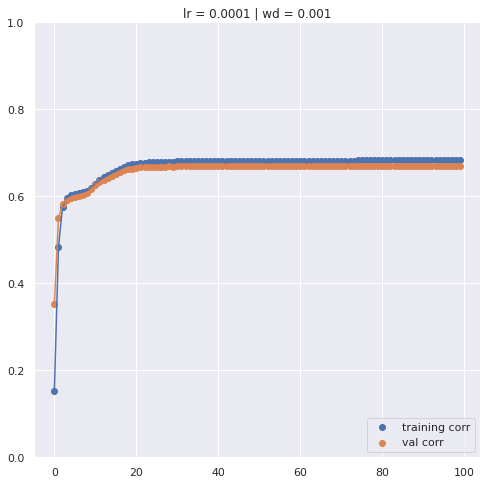

In [21]:
figsize(8, 8)
plt.scatter(list(range(epochs)), train_corrs, label='training corr')
plt.plot(list(range(epochs)), train_corrs)
plt.scatter(list(range(epochs)), val_corrs, label='val corr')
plt.plot(list(range(epochs)), val_corrs)
plt.legend(loc='lower right')
plt.title(f'lr = {learning_rate} | wd = {weight_decay}')
plt.ylim(0, 1)

In [22]:
del train_inp, train_tar, full_ds, train_ds, val_ds, train_loader, val_loader
gc.collect()

3343

In [23]:
%%time
torch.save(net, 'mlp_multi.pt')

CPU times: user 124 ms, sys: 232 ms, total: 355 ms
Wall time: 359 ms


## Prediction

In [24]:
# %%time
# test_inp = scipy.sparse.load_npz(f'{DATA_DIR}/test_multi_inputs_val.sparse.npz')
# test_inp.shape

In [25]:
# class SparsePredDataset(TensorDataset):
#     # https://discuss.pytorch.org/t/dataloader-loads-data-very-slow-on-sparse-tensor/117391/2
#     def __init__(self, inputs):
#         self.inputs = inputs
    
#     def __getitem__(self, index):
#         return self.inputs[index]
    
#     def __len__(self):
#         return self.inputs.shape[0]

In [26]:
# def sparse_batch_collate_pred(batch):
#     return sparse_coo_to_tensor(scipy.sparse.vstack(batch).tocoo())

In [27]:
# test_ds = SparsePredDataset(test_inp)
# test_loader = DataLoader(test_ds, 
#                          batch_size=batch_size, 
#                          shuffle=False,
#                          collate_fn=sparse_batch_collate_pred)

In [28]:
# %%time
# with torch.no_grad():
#     net.eval()
#     test_tar_preds = []
    
#     for i, x in enumerate(test_loader):
#         x = x.to(device)
#         batch_preds = net(x).to('cpu').detach().numpy()
#         test_tar_preds.append(batch_preds)

In [29]:
# del test_inp, test_ds, test_loader
# gc.collect()

In [30]:
# test_tar_preds = np.vstack(test_tar_preds)
# print(test_tar_preds.shape)

In [31]:
# gc.collect()

In [32]:
# dump_pickle(test_tar_preds, 'test_tar_preds')

## Creating Submission

In [33]:
# DATA_DIR = '../input/msci-h5-sparse-transform'
# %ls $DATA_DIR -lh

In [34]:
# test_tar_cols = np.load(f'{DATA_DIR}/train_multi_targets_idx.npz',
#                         allow_pickle=True)['columns']
# test_tar_idx = np.load(f'{DATA_DIR}/test_multi_inputs_idx.npz',
#                        allow_pickle=True)['index']
# test_tar_cols.shape, test_tar_idx.shape, test_tar_preds.shape

In [35]:
# %%time
# print('Start Eval...')
# eval_ids = pd.read_parquet(f'{DATA_DIR}/evaluation_ids.parquet')
# eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
# eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())

In [36]:
# %%time
# sub = pd.Series(name='target',
#                 index=pd.MultiIndex.from_frame(eval_ids), 
#                 dtype=np.float32)
# sub

In [37]:
# cell_id_dict = {cell_id: idx 
#                 for idx, cell_id in enumerate(test_tar_idx, 0)}
# gene_id_dict = {gene_id: idx 
#                 for idx, gene_id in enumerate(test_tar_cols, 0)}

In [38]:
# eid_cid_idx = eval_ids['cell_id']\
#               .apply(lambda x: cell_id_dict.get(x, -1))
# eid_gid_idx = eval_ids['gene_id']\
#               .apply(lambda x: gene_id_dict.get(x, -1))
# valid_multi_rows = (eid_cid_idx != -1) & (eid_gid_idx != -1)

In [39]:
# del eval_ids
# gc.collect()

In [40]:
# %%time
# sub.iloc[valid_multi_rows] = test_tar_preds\
#                              [eid_cid_idx[valid_multi_rows].to_numpy(),
#                               eid_gid_idx[valid_multi_rows].to_numpy()]

In [41]:
# del test_tar_idx, test_tar_cols
# del eid_cid_idx, eid_gid_idx, valid_multi_rows
# gc.collect()

In [42]:
# sub = pd.DataFrame(sub).fillna(0).reset_index()
# sub.drop(['cell_id', 'gene_id'], axis=1)\
#    .to_csv('multi_sub.csv', index=False)

In [43]:
# sub.tail()